# Notebook to explore the Genetic method applied to the 3MdB models

Import some libraries. Download and install if necessary.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
try:
    import pymysql
except:
    !pip install pymysql
    import pymysql
import pandas as pd
from ai4neb import manage_RM
%matplotlib inline
import corner
dir_RMs = 'RMs/'
dir_figs = 'Figs/'
dir_CSVs = 'CSVs/'

2023-08-11 17:58:04.171244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/christophemorisset/anaconda3/envs/ML/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Define function to download, save and restore the data from 3MdB. 

The following environment variables storing the connection parameters need to be defined:
* MdB_HOST
* MdB_USER
* MdB_PASSWD
* MdB_DB_17

In [2]:
def to_hdf(file_, df, metadata=None):
    with pd.HDFStore(file_) as store:
        store.put('df', df)
        store.get_storer('df').attrs.metadata = metadata                     

def read_hdf(file_):                     
    with pd.HDFStore(file_) as store:
        df = store['df']
        metadata = store.get_storer('df').attrs.metadata
    return df, metadata

In [3]:
def get_data_17(datafile='data_BOND_17_2.hdf5', force=False):
    if not os.path.exists(dir_CSVs + datafile) or force:
        sel = """SELECT
                log10(O__3_500684A/H__1_486133A) as O3,  
                log10(N__2_658345A/H__1_486133A) as N2, 
                log10(BLND_372700A/H__1_486133A) as O2, 
                log10((NE_3_386876A + NE_3_396747A)/H__1_486133A) as Ne3,
                log10(AR_3_713579A/H__1_486133A) as Ar3,
                log10(HE_1_587564A/H__1_486133A) as He1,
                log10(BLND_436300A/O__3_500684A) as rO3,
                log10(BLND_575500A/N__2_658345A) as rN2,
                log10((S__2_673082A+S__2_671644A)/H__1_486133A) as S2,
                NITROGEN - OXYGEN as NO,
                OXYGEN as O,
                logU_mean as logU,
                SUBSTRING(com2, 5) as fr,
                SUBSTRING(com3, 6) as age,
                HbFrac
                FROM tab_17
                WHERE ref = 'BOND_2'"""
        db = pymysql.connect(host=os.environ['MdB_HOST'], 
                                user=os.environ['MdB_USER'], 
                                passwd=os.environ['MdB_PASSWD'], 
                                db=os.environ['MdB_DB_17'])    
        res = pd.read_sql(sel, con=db)
        res.fr = res.fr.astype('float64') 
        res.age = res.age.astype('float64')/1e6
        db.close()
        to_hdf(dir_CSVs + datafile, res, sel)
    else:
        res, sel = read_hdf(dir_CSVs + datafile)
    return res

res = get_data_17(force=False)
print(len(res))
# Keep only mainly radiation bounded nebulae
mask = res.HbFrac > 0.80
res = res[mask]
res['O'] = 12 + res['O']
print(len(res))

210600
42122


Define the variables used for the ML, as inputs and outputs

In [4]:
X_keys_3 = ['O', 'NO', 'logU']
X_keys_4 = ['O', 'NO', 'logU', 'age']
X_keys_5 = ['O', 'NO', 'logU', 'age', 'fr']

y_keys_3 = ['O3', 'N2', 'O2']
y_keys_3b = ['O3', 'N2', 'S2']
y_keys_6 = ['O3', 'N2', 'O2', 'Ne3', 'Ar3', 'He1']
y_keys = y_keys_3b

In [26]:
# Using NebulaBayes data for training. !!! N/O vs. O/H is fixed !!!
# Was for testing purpose, let the following to False
if False: 
    mapsmods = pd.read_csv(dir_CSVs + 'mapsmods.csv.gz')
    OH_ori = np.array([-4.939 , -4.3369, -3.939 , -3.6379, -3.3949, -3.24  , -3.1261,
       -3.0096, -2.9178, -2.8421, -2.7629, -2.6959]) -0.11 + 12
    NH_ori = np.array([-6.6331, -5.9296, -5.3803, -4.9061, -4.4888, -4.2099, -3.9997,
       -3.781 , -3.6066, -3.4614, -3.3086, -3.1788]) -0.04 + 12
    OH = mapsmods['12 + log O/H'].copy() - 0.11
    NH = mapsmods['12 + log O/H'].copy() - 0.04
    for oh, nh in zip(OH_ori, NH_ori):
        NH[np.abs(OH - oh) < 0.01] = nh
    X_train = np.array((OH, NH-OH, mapsmods['log U'])).T
    y_train = np.log10(np.array((mapsmods['OIII5007'],
                        mapsmods['NII6583'],
                        mapsmods['OII3726'] + mapsmods['OII3729'],
                        mapsmods['NeIII3869'],
                        mapsmods['HeI5876']))).T
    y_train = np.log10(np.array((mapsmods['OIII5007'],
                        mapsmods['NII6583'],
                        mapsmods['OII3726'] + mapsmods['OII3729']))).T
    mask = np.isfinite(y_train).sum(1) == 3
    X_train = X_train[mask]
    y_train = y_train[mask]
    f, ax = plt.subplots()
    ax.scatter(X_train[:,0], X_train[:,1])

## Define the ML Regressor

In [6]:
def get_RM(filename, force=False):
    train_RM = True
    if not force:
        # Download an already trained regressor
        RM = manage_RM(RM_filename=dir_RMs + filename)
        if RM.N_in != 0:
            train_RM = False
            RM.predict(scoring=True)
    if train_RM:
        solver = 'lbfgs'
        activation = 'tanh'
        RM = manage_RM(RM_type='SK_ANN', X_train=X_train, y_train=y_train, verbose=True, 
                              scaling=True, split_ratio=0.2)
        #RM.init_RM(epochs=5000, solver=solver, activation=activation, 
        #            hidden_layer_sizes=(50, 50, 20, 20), dropout=(0, 0.2, 0.2, 0.2))
        RM.init_RM(max_iter=20000, tol=1e-8 , solver=solver, activation=activation, 
                    hidden_layer_sizes=(50, 50, 50))
        RM.train_RM()
        RM.predict(scoring=True)
        RM.verbose = False
        RM.save_RM(dir_RMs + filename, save_train=True, save_test=True)
    return RM

Set up various regressors

In [8]:
# Define how many output we will use:
N_in, N_out = 4, 3

force = False

if N_in == 4 and N_out == 6 :
    X_train = np.array(res[X_keys_4])
    y_train = np.array(res[y_keys_6])
    RM6 = get_RM('y6_X4', force=force)
    RM6b = get_RM('y6_X4b', force=force)
    RM6c = get_RM('y6_X4c', force=force)
    RM6d = get_RM('y6_X4d', force=force)
    RM6e = get_RM('y6_X4e', force=force)
    RM6f = get_RM('y6_X4f', force=force)
    RM6g = get_RM('y6_X4g', force=force)
    RM6h = get_RM('y6_X4h', force=force)
    RM6i = get_RM('y6_X4i', force=force)
    y_keys = y_keys_6
    RMs = [RM6, RM6b, RM6c, RM6d, RM6e, RM6f, RM6g, RM6i]
elif N_in == 5 and N_out == 6 :
    X_train = np.array(res[X_keys_5])
    y_train = np.array(res[y_keys_6])
    RM65 = get_RM('y6_X5', force=force)
    RM65b = get_RM('y6_X5b', force=force)
    RM65c = get_RM('y6_X5c', force=force)
    y_keys = y_keys_6
    RMs = [RM65, RM65b, RM65c]
elif N_in == 3 and N_out == 3:
    X_train = np.array(res[X_keys_3])
    y_train = np.array(res[y_keys_3])
    RM33 = get_RM('y3_X3', force=force)
    RM33b = get_RM('y3_X3b', force=force)
    RM33c = get_RM('y3_X3c', force=force)
    RMs = [RM33, RM33b, RM33c]
elif N_in == 5 and N_out == 3:
    X_train = np.array(res[X_keys_5])
    y_train = np.array(res[y_keys_3])
    RM35b = get_RM('y3_X5b', force=force)
    RM35c = get_RM('y3_X5c', force=force)
    RMs = [RM35b, RM35c]
elif N_in == 4 and N_out == 3:
    X_train = np.array(res[X_keys_4])
    y_train = np.array(res[y_keys_3])
    RM3 = get_RM('y3b_X4', force=force)
    """
    RM3b = get_RM('y3_X4b', force=force)
    RM3c = get_RM('y3_X4c', force=force)
    RM3d = get_RM('y3_X4d', force=force)
    RM3e = get_RM('y3_X4e', force=force)
    RM3f = get_RM('y3_X4f', force=force)
    RM3g = get_RM('y3_X4g', force=force)
    RMs = [RM3, RM3b, RM3c, RM3d, RM3e, RM3f, RM3g]
    """
    RMs = [RM3,]
elif N_out == 5:
    RMs = [RM5, RM5b, RM5c]
RM = RMs[0]

Define plotting functions

In [9]:
def plot1(RM):
    f, axes = plt.subplots(3, 2, figsize=(10,10))
    for i, ax in enumerate(axes.ravel()):
        ax.scatter(RM.y_test[:,i], RM.pred[:,i], alpha=0.1, marker='.')
        ax.set_title(y_keys[i])
        ax.set_xlim((-4,2))
        ax.set_ylim((-4,2))
    f.tight_layout()
def plot2(RM):
    f, axes = plt.subplots(3, 2, figsize=(10,10))
    lims = .2
    for i, ax in enumerate(axes.ravel()[0:RM.y_test.shape[1]]):
        #print('ploting', i, y_keys[i])
        max = RM.y_test[:,i].max()
        mask = RM.y_test[:,i] > max - 4
        dif = (RM.pred[mask,i].ravel() - RM.y_test[mask,i].ravel())
        med = np.median(dif)
        std = np.sqrt(np.mean((dif-med)**2))
        ax.hist(dif, bins=np.linspace(-lims, lims, 100))
        ax.set_xlim(-lims,lims)
        ax.set_title('{} MED = {:.3f}, STD={:.3f} dex'.format(y_keys[i], med, std))
    f.tight_layout()

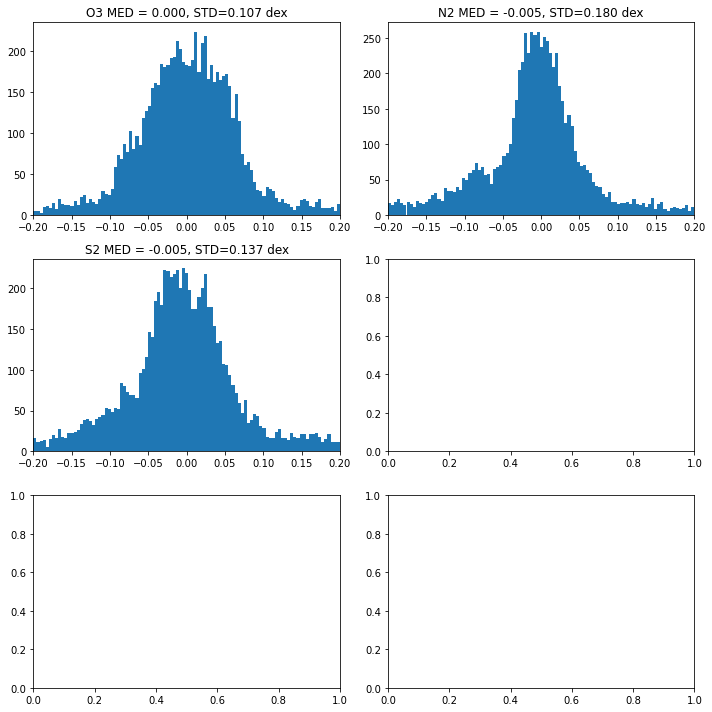

In [10]:
plot2(RMs[0])

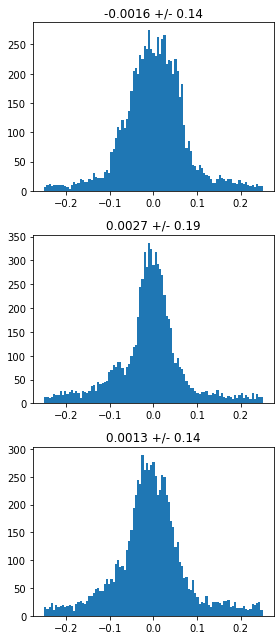

In [11]:
f, axes = plt.subplots(RM.N_out, 1, figsize=(4, 3*RM.N_out))
RM_quality = RM.pred - RM.y_test
for i, ax in enumerate(axes.ravel()):
    x = RM_quality[:,i]
    ax.hist(x, bins=np.linspace(-.25, .25, 100))
    ax.set_title('{:.4f} +/- {:.2f}'.format(np.mean(x), np.std(x)))
f.tight_layout()

In [27]:
if False:
    P = pd.DataFrame(X_train.min(0) + (X_train.max(0) - X_train.min(0)) * np.random.rand(20000, X_train.shape[1]))
    P = pd.DataFrame(X_train[0:2000])
    for RM1 in RMs:
        RM1.set_test(np.array(P))
        RM1.predict()
    f, axes = plt.subplots(RM.N_out, 1, figsize=(7, 3*RM.N_out))
    for i, ax in enumerate(axes.ravel()):
        x = RMs[0].pred[:,i]- RMs[1].pred[:,i]
        ax.hist([RMs[0].pred[:,i]- RMs[1].pred[:,i],RMs[0].pred[:,i]- RMs[2].pred[:,i]], bins=np.linspace(-.25, .25, 100))
        ax.set_title('{:.4f} +/- {:.2f}'.format(np.mean(x), np.std(x)))
    f.tight_layout()
    # Hay un problema serio por aca!!!

0.134360201912829 0.134360201912829


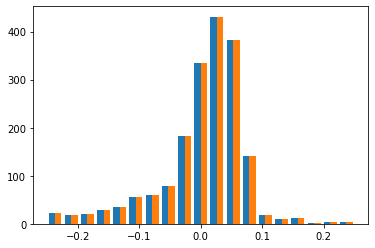

In [28]:
P1 = pd.DataFrame(X_train.min(0) + (X_train.max(0) - X_train.min(0)) * np.random.rand(2000, X_train.shape[1]))
P2 = pd.DataFrame(X_train[0:2000])
pred1 = []
pred2 = []
for rm in RMs:
    rm.set_test(np.array(P1))
    rm.predict()
    pred1.append(rm.pred[:,0:3])
    rm.set_test(np.array(P2))
    rm.predict()
    pred2.append(rm.pred[:,0:3])
pm1 = np.array(pred1).mean(0)
pm2 = np.array(pred2).mean(0)

plt.hist([pm2[:,0]-y_train[0:2000,0], rm.pred[:,0]-y_train[0:2000,0]], bins=np.linspace(-.25, .25, 20))
print(np.std(pm2[:,0]-y_train[0:2000,0]), np.std(rm.pred[:,0]-y_train[0:2000,0]));

## Solve the inverse problem using Genetic method

### Define the target we want to fit

In [56]:
# Define the target we want to fit using a "real" value:
if False:
    if N_out == 6:
        target = np.log10(np.array([1.00, 0.83, 2.53, 0.048, 0.065, 0.119])) # Bresolin 2005, NGC 123, region 5
    elif N_out == 3:
        target = np.log10(np.array([1.00, 0.83, 2.53])) # Bresolin 2005, NGC 123, region 5
        target = np.log10(np.array([3.1, 1.9, 4.5])) # PD+21 NGC185
        target = np.log10(np.array([3.7, 0.11, 0.15])) # PD+21 IC10
        target = np.log10(np.array([2.1, 8., 4.6])) # PD+21 NGC315
        target = np.log10(np.array([0.21, 0.20, 0.7])) # PD+21 IC2574
    elif N_out == 5:
        target = np.log10(np.array([1.00, 0.83, 2.53, 0.048, 0.119]))

    if N_in == 3:
        X_target = np.array([8.72, -1, -3])
    elif N_in == 4:
        X_target = np.array([8.72, -1, -3, 3])
        X_target = np.array([8.7, -1.1, -3.35, -1])# PD+21 NGC185
        X_target = np.array([7.858, -1., -2.45, -1])# PD+21 IC10
        X_target = np.array([8.79, -.5, -3.46, -1])# PD+21 NGC315
        X_target = np.array([8.73, -1.35, -3.27, -1])# PD+21 IC2574
    elif N_in == 5:
        X_target = np.array([8.72, -1, -3, 3, 0.1])
        X_target = np.array([8.7, -1.1, -3.35, -1, -1])# PD+21 NGC185
        X_target = np.array([7.858, -1., -2.45, -1, -1])# PD+21 IC10
        X_target = np.array([8.79, -.5, -3.46, -1, -1])# PD+21 NGC315
        X_target = np.array([8.73, -1.35, -3.27, -1, -1])# PD+21 IC2574

# Define the target as a model of the grid, refered by ML input values (what we want to determine).
if True:
    # Look for models that are close to a point we want to set as target.
    bidx1 = np.isclose(RMs[0].X_train_unscaled[:,0], 8.2, 0.01) # 12 + log O/H
    bidx2 = np.isclose(RMs[0].X_train_unscaled[:,1], -1., 0.1) # log N/O
    bidx3 = np.isclose(RMs[0].X_train_unscaled[:,2], -3., 0.05) # log U
    if N_in == 3:
        bidx = (bidx1 & bidx2 & bidx3)
    elif N_in == 4:    
        bidx4 = np.isclose(RMs[0].X_train_unscaled[:,3], 1, 0.05) # age / 1e6 yr
        bidx = (bidx1 & bidx2 & bidx3 & bidx4)
    elif N_in == 5:    
        bidx4 = np.isclose(RMs[0].X_train_unscaled[:,3], 1, 0.05) # age / 1e6 yr
        bidx5 = np.isclose(RMs[0].X_train_unscaled[:,4], 3, 0.05) # fr
        bidx = (bidx1 & bidx2 & bidx3 & bidx4 & bidx5)    
    bidx = (bidx1 & bidx2 & bidx3 & bidx4)
    idx = np.where(bidx)[0]
    print(bidx1.sum(),bidx2.sum(), bidx3.sum(), bidx4.sum(), bidx.sum())
    print('Indexes of the models', idx)
    target = RMs[0].y_train_unscaled[idx[0]]
    X_target = RMs[0].X_train_unscaled[idx[0]]

# Define the target as a model of the grid, refered by index
if False:
    N_target = 2347
    # 4717 : 2 solution, good one high
    # 3496 : 2 solutions
    # 2347 : 2 solution, good one faint
    target = RMs[0].y_train_unscaled[N_target]
    X_target = RMs[0].X_train_unscaled[N_target]

print(X_target, target)

2251 3750 2657 5609 2
Indexes of the models [16741 18281]
[ 8.2     -1.      -3.02076  1.     ] [ 0.38151153 -0.22810472  0.58346982]


Define the function the method will minimize

In [57]:
def model_v(p2):
    """ 
    Return the model. Single RM version
    p2 is a list of vectors of O/H, N/O, logU, age"""
    RM.set_test(np.array(p2))
    RM.predict()
    model = RM.pred
    return model

def model_v2(p2):
    """ 
    Return the model. Multi RM version: return the mean
    p2 is a list of vectors of O/H, N/O, logU, age"""
    pred1 = []
    for rm in RMs:
        rm.set_test(p2)
        rm.predict()
        pred1.append(rm.pred)
    #print(pred1)
    return np.mean(np.array(pred1),0)

# Define the elemental function for the vectorized MCMC
def lnprob_v(p2, target=target):
    """ p2 is a list of vectors """
    #ToDo: add tolerance?
    mask = ((p2 >= X_train.min(0)) & (p2 <= X_train.max(0))).sum(1) != X_train.shape[1]
    #res = - np.sum((model_v2(p2) - target)**2, 1)
    res = np.log10(1. / (np.sum((model_v(p2) - target)**2, 1)))
    res[mask] = -np.inf
    return res

Test the behaviour of the functions

In [58]:
# Test multiple values for vectorization
if RM.N_in == 4:
    p2 = np.array([[8., -1.0, -2.33, 3], [8.1, -1.1, -2.2, 3.1], [14.1, -1.1, -2.2, 3.1]]) # last element out of range for test
elif RM.N_in == 3:
    p2 = np.array([[8., -1.0, -2.33], [8.1, -1.1, -2.2], [14.1, -1.1, -2.2]]) # last element out of range for test
elif RM.N_in == 5:
    p2 = np.array([[8., -1.0, -2.33, 3, 0.03], [8.1, -1.1, -2.2, 3.1, 0.03], [14.1, -1.1, -2.2, 3.1, 0.1]]) # last element out of range for test

#p2 = RMs[0].X_train_unscaled[0:3]
#p2[0] = X_target
p2_out = RMs[0].y_train[0:3]
p2_out[0] = target
print('p2')
print(p2)
print('model_v(p2)')
print(model_v(p2))
print('model_v2(p2)')
print(model_v2(p2))
print('y values for p2')
print(p2_out)
print('lnprob_v for p2')
print(lnprob_v(p2))

p2
[[ 8.   -1.   -2.33  3.  ]
 [ 8.1  -1.1  -2.2   3.1 ]
 [14.1  -1.1  -2.2   3.1 ]]
model_v(p2)
[[ 0.54634941 -0.81814845  0.24875495]
 [ 0.58421351 -0.91095886  0.25318381]
 [-6.3309106  -3.10176647  3.03151829]]
model_v2(p2)
[[ 0.54634941 -0.81814845  0.24875495]
 [ 0.58421351 -0.91095886  0.25318381]
 [-6.3309106  -3.10176647  3.03151829]]
y values for p2
[[ 0.38151153 -0.22810472  0.58346982]
 [ 0.54922654 -1.18524924 -0.04600363]
 [ 0.74979668 -1.46145439  0.3583324 ]]
lnprob_v for p2
[0.31215265 0.21009037       -inf]


In [59]:
if False:
    ln_res = []
    for xx, tt in zip(RMs[0].X_train_unscaled, RMs[0].y_train_unscaled):
        ln_res.append(lnprob_v(np.array([xx]), target=tt)[0])
    f, ax = plt.subplots()
    ax.hist(ln_res, bins=np.linspace(-0.5, 0,100),log=True);

### Main Genetic Method loop (takes a few minutes)

In [60]:
ndim = X_train.shape[1]
mod_res_cut = -25 # cut to remove models at each generation
first_G = 20000 # Number of models at the first generation
N_runs = 3 # Run N_runs the Genetic algo. Append all the results in P_all
N_generations = 40 #50 # number of generations
N_select = 30 #100 # number of models selected for the reproduction
N_descend = 100 #20 # number of models from mutation of one model G-1
P_all = []
i_gen_alpha = 0.7 # 0.7
NOvOH_NB = lambda x: 0.25*(x - 7)**2 - 1.6

for i_run in np.arange(N_runs):
    P = pd.DataFrame(X_train.min(0) + (X_train.max(0) - X_train.min(0)) * np.random.rand(first_G, ndim))
    P.rename(columns={0: '12 + log O/H', 1: 'log N/O', 2: 'log U', 3: 'age', 4: 'fr'}, inplace=True)
#    P['log N/O'] = NOvOH_NB(P['12 + log O/H']) + np.random.randn(first_G)*0.2
    P['mod_res'] = lnprob_v(P, target)
    P.drop(P[P['mod_res'] < mod_res_cut].index, inplace=True)
    P['G'] = 1    
    Delta_OH = 0.2 * (P['12 + log O/H'].max() - P['12 + log O/H'].min())
    Delta_NO = 0.2 * (P['log N/O'].max() - P['log N/O'].min())
    Delta_logU = 0.2 * (P['log U'].max() - P['log U'].min())
    if RM.N_in >= 4:
        Delta_age = 0.5 * (P['age'].max() - P['age'].min())
    for i_gen in np.arange(N_generations-1)+1:
        coeff = i_gen**i_gen_alpha 
        P_select = P.sort_values('mod_res', ascending=False).head(N_select)
        for i, p in P_select.iterrows():
            if RM.N_in == 3:
                P_new = pd.DataFrame(np.array([p['12 + log O/H'] + np.random.randn(N_descend) * Delta_OH / coeff,
                                  p['log N/O'] + np.random.randn(N_descend) * Delta_NO / coeff,
                                  p['log U'] + np.random.randn(N_descend) * Delta_logU / coeff]).T)
            elif RM.N_in == 4:
                P_new = pd.DataFrame(np.array([p['12 + log O/H'] + np.random.randn(N_descend) * Delta_OH / coeff,
                                  p['log N/O'] + np.random.randn(N_descend) * Delta_NO / coeff,
#                                  NOvOH_NB(p['12 + log O/H']) + np.random.randn(N_descend) / coeff,
                                  p['log U'] + np.random.randn(N_descend) * Delta_logU / coeff,
                                  p['age'] + np.random.randn(N_descend) * Delta_age / coeff]).T)
            elif RM.N_in == 5:
                P_new = pd.DataFrame(np.array([p['12 + log O/H'] + np.random.randn(N_descend) * Delta_OH / coeff,
                                  p['log N/O'] + np.random.randn(N_descend) * Delta_NO / coeff,
                                  p['log U'] + np.random.randn(N_descend) * Delta_logU / coeff,
                                  p['age'] + np.random.randn(N_descend) * Delta_age / coeff,
                                  p['fr'] * 10**(np.random.randint(0, 3, size=N_descend))]).T)
                
            P_new.rename(columns={0: '12 + log O/H', 1: 'log N/O', 2: 'log U', 3: 'age', 4: 'fr'}, inplace=True)
            P_new['mod_res'] = lnprob_v(P_new)
            P_new.drop(P_new[P_new['mod_res'] < mod_res_cut].index, inplace=True)
            P_new['G'] = i_gen+1
            P = P.append(P_new)
    if i_run == 0:
        P_all = P
    else:
        P_all = P_all.append(P)

In [61]:
# Total number of models:
P_all.count()['G']

388673

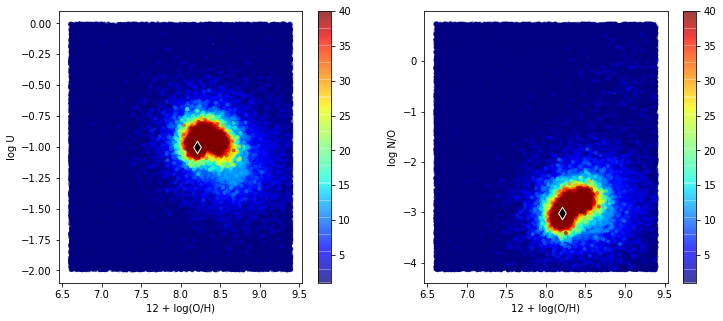

In [62]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
sc1 = ax1.scatter(P_all['12 + log O/H'], P_all['log N/O'], c=P_all['G'], alpha=0.5, cmap='jet', marker='.')
f.colorbar(sc1, ax=ax1)
mask = P_all['mod_res'] > 3
#ax1.scatter(P_all['12 + log O/H'][mask], P_all['log N/O'][mask])
ax1.scatter(X_target[0], X_target[1], c='k', marker='d', s=80, edgecolor='w')
ax1.set_xlabel('12 + log(O/H)')
ax1.set_ylabel('log U')

sc2 = ax2.scatter(P_all['12 + log O/H'], P_all['log U'], c=P_all['G'], alpha=0.5, cmap='jet', marker='.')
f.colorbar(sc2, ax=ax2)
mask = P_all['mod_res'] > 3
#ax2.scatter(P_all['12 + log O/H'][mask], P_all['log U'][mask])
ax2.scatter(X_target[0], X_target[2], c='k', marker='d', s=80, edgecolor='w')
ax2.set_xlabel('12 + log(O/H)')
ax2.set_ylabel('log N/O');

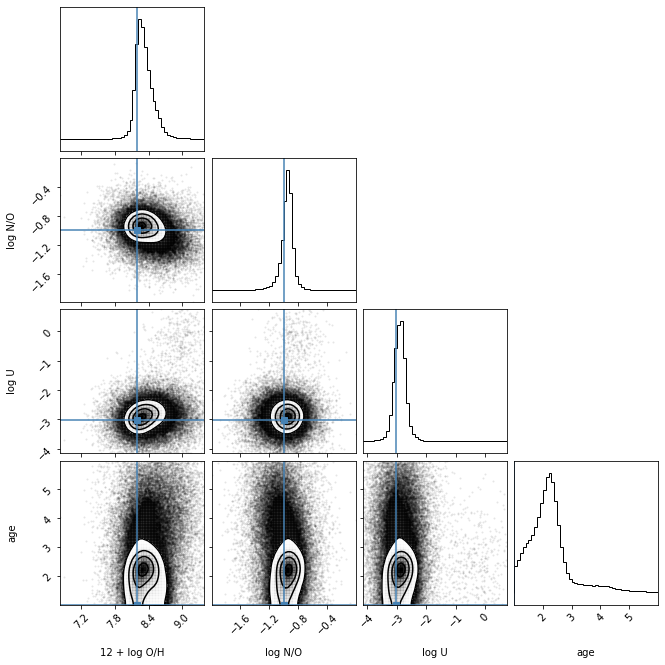

In [63]:
mask_G = P_all['G'] > 2
if 'fr' in P_all.columns:
    Pcorner = P_all[mask_G][['12 + log O/H', 'log N/O', 'log U', 'age', 'fr']]
elif 'age' in P_all.columns:
    Pcorner = P_all[mask_G][['12 + log O/H', 'log N/O', 'log U', 'age']]
else:
    Pcorner = P_all[mask_G][['12 + log O/H', 'log N/O', 'log U']]
f = corner.corner(Pcorner, bins=50, smooth=2, truths=X_target,  scale_hist=True)
#                  range=[(6.5, 9.5),(-2, 0), (-4, 1), (1, 6)],)
f.savefig('Figs/IC2574.png')

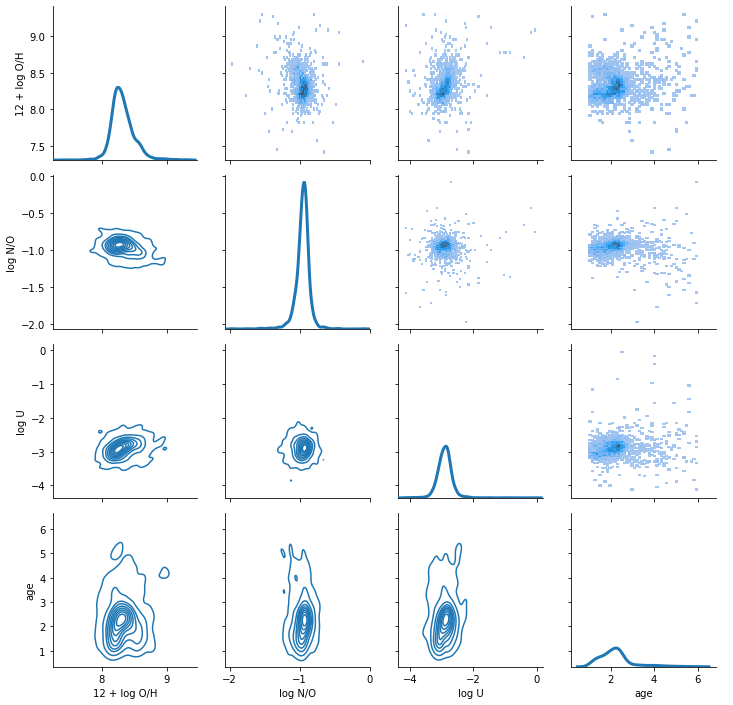

In [64]:
import seaborn as sns
N_sample = 2000
mask_G = P_all['G'] > 1
Psns = P_all[mask_G][['12 + log O/H', 'log N/O', 'log U']]
if 'fr' in P_all.columns:
    Psns['fr'] = P_all[mask_G]['fr']
if 'age' in P_all.columns:
    Psns['age'] = P_all[mask_G]['age']    
#Psns['G'] = P_all[mask_G]['G']
Psns = Psns.sample(N_sample)
g = sns.PairGrid(Psns, palette="cubehelix")
#g.map_upper(sns.scatterplot, alpha=0.01)
g.map_upper(sns.histplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)
g.map_lower(sns.kdeplot);  # Takes time, use N_sample ~1000!
g.add_legend();

It seems that the result is not the same with 3 or 6 lines. Check that the same X gives the same y for the 3 main lines, in the 3- and 6-outputs ANNs. 

RESULT: That's not the case :-(

In [65]:
# Brut force on Cartesian grid
N = 20 # size of the grid
print(N**4) # number of models
mesh = np.array(np.meshgrid(np.linspace(X_train.min(0)[0], X_train.max(0)[0], N),
                np.linspace(X_train.min(0)[1], X_train.max(0)[1], N),
                np.linspace(X_train.min(0)[2], X_train.max(0)[2], N),
                np.linspace(X_train.min(0)[3], X_train.max(0)[3], N))).reshape(4, -1)
P = pd.DataFrame(mesh.T)
P.rename(columns={0: '12 + log O/H', 1: 'log N/O', 2: 'log U', 3: 'age'}, inplace=True)
P['mod_res'] = lnprob_v(P, target)

160000


In [66]:
print(P.nunique())

12 + log O/H        20
log N/O             20
log U               20
age                 20
mod_res         160000
dtype: int64


In [67]:
# Set to 1 the best models, to 0. the others
mask = P['mod_res'] > -0.1 # ToDo: redefine lnprob to have some more intuitive meaning, in terms of obs uncertainties
P['mod_res'][mask] = 1
P['mod_res'][~mask] = 0

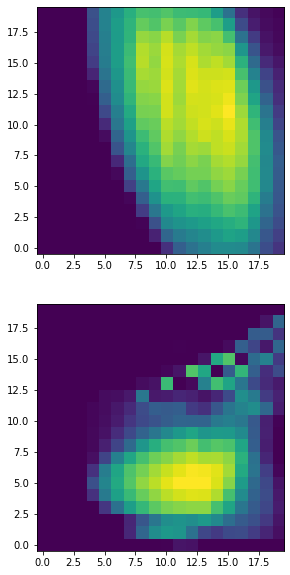

In [68]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,10))
# Sum up on age and logU:
ax1.imshow(P.groupby(['12 + log O/H', 'log N/O'])['mod_res'].sum().values.reshape(N, N).T, origin='lower')
ax2.imshow(P.groupby(['12 + log O/H', 'log U'])['mod_res'].sum().values.reshape(N, N).T, origin='lower');